In [72]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

from datetime import time, timedelta
import matplotlib.dates as mdates
from datetime import datetime

from MAppServer.settings import DOWNLOAD_FOLDER_ABSOLUTE_PATH


In [67]:
file = ""
for file_ in glob.glob(f"{DOWNLOAD_FOLDER_ABSOLUTE_PATH}/users*.csv"):
    file = file_
    break

print("Users file:", file)

Users file: /Users/aureliennioche/Documents/PythonProjects/MAppServer/data/dump_latest/users_2023-07-12_23-36-02.csv


In [68]:
df = pd.read_csv(file, index_col=0)
users = df.user.values

In [102]:
df_step_content = []

for user in tqdm(users):

    if "smallobj" in user or "michele" in user or "student" in user:
        print(f"Skipping user `{user}` (test user)")
        continue

    file = ""
    for file_ in glob.glob(f"{DOWNLOAD_FOLDER_ABSOLUTE_PATH}/{user}_reward*.csv"):
        file = file_
        break
    df_rwd = pd.read_csv(file, index_col=0)
    df_rwd["dt"] = pd.to_datetime(df_rwd["date"], utc=False)
    df_rwd["dt"] = df_rwd["dt"].dt.tz_localize('Europe/London')

    for file_ in glob.glob(f"{DOWNLOAD_FOLDER_ABSOLUTE_PATH}/{user}_activity*.csv"):
        file = file_
        break
    df_act = pd.read_csv(file, index_col=0)
    if len(df_act) < 100:
        print(f"Skipping user `{user}`, not enough activity records (n={len(df_act)})")
        continue

    df_act.dt = pd.to_datetime(df_act.dt, utc=False)
    df_act.dt = df_act.dt.dt.tz_convert('Europe/London')

    n_days = len(df_act.dt.dt.date.unique())

    if n_days < 3:
        print(f"Skipping user `{user}`, not enough days (n={n_days})")
        continue

    conditions = df_rwd.condition.unique()

    for cond in conditions:
        df_rwd_cond = df_rwd[df_rwd.condition == cond]
        uniq_date = df_rwd_cond["dt"].dt.date.unique()
        for date in uniq_date:
            if date >= datetime.now().date():
                continue

            df_act_that_day = df_act[df_act["dt"].dt.date == date]
            if len(df_act_that_day) == 0:
                continue
            y = df_act_that_day.step_midnight.values
            try:
                # Patch in case of re-installation
                if np.sum(np.diff(y) < 0) > 0:
                    idx = 1 + np.arange(len(y)-1)[np.diff(y) < 0][0]
                    y[idx:] = y[idx:] - y[idx]
                    if idx >= 1:
                        y[idx:] += y[idx-1]

                df_step_content.append({"date": date, "step": max(y), "condition": cond, "user": user})
            except:
                pass

df_step = pd.DataFrame(df_step_content)


  7%|▋         | 3/46 [00:00<00:02, 21.37it/s]

Skipping user `13SK`, not enough activity records (n=0)
Skipping user `182E`, not enough activity records (n=0)


 24%|██▍       | 11/46 [00:02<00:10,  3.32it/s]

Skipping user `06DS`, not enough activity records (n=0)


 37%|███▋      | 17/46 [00:04<00:08,  3.45it/s]

Skipping user `michele_beta1` (test user)


 61%|██████    | 28/46 [00:07<00:03,  4.74it/s]

Skipping user `23MI`, not enough activity records (n=1)


 63%|██████▎   | 29/46 [00:07<00:05,  3.18it/s]

Skipping user `smallobj` (test user)


 70%|██████▉   | 32/46 [00:09<00:05,  2.61it/s]

Skipping user `student_a_beta1` (test user)


 83%|████████▎ | 38/46 [00:11<00:02,  3.10it/s]

Skipping user `07EI`, not enough activity records (n=1)


100%|██████████| 46/46 [00:12<00:00,  3.60it/s]


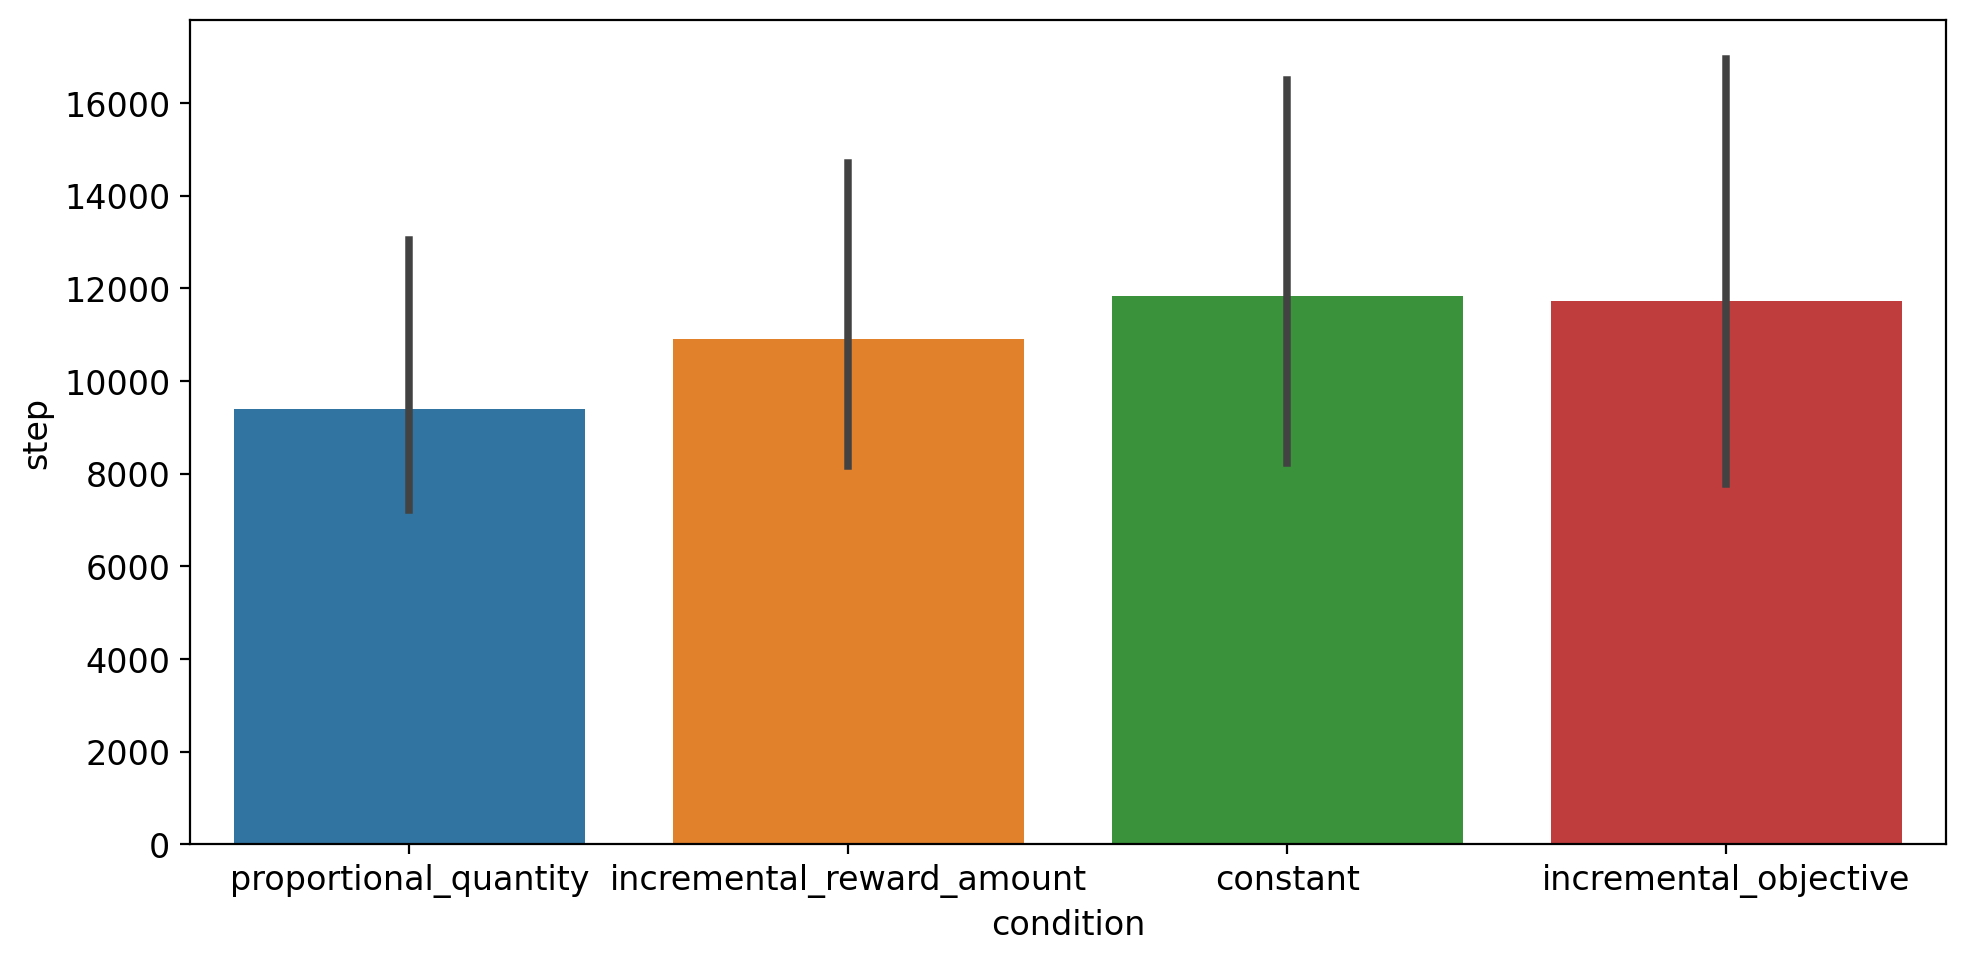

In [107]:
order = df_step.condition.unique()

plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x="condition", y="step", data=df_step, ax=ax, order=order)
fig.tight_layout()

user 02TA


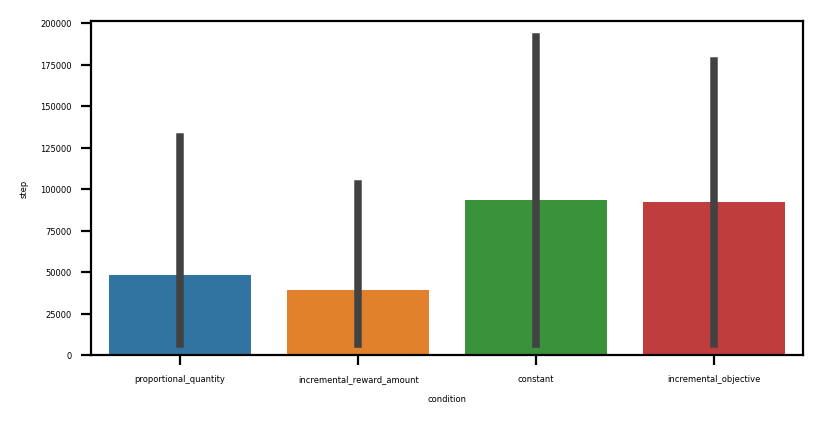

user 12AE


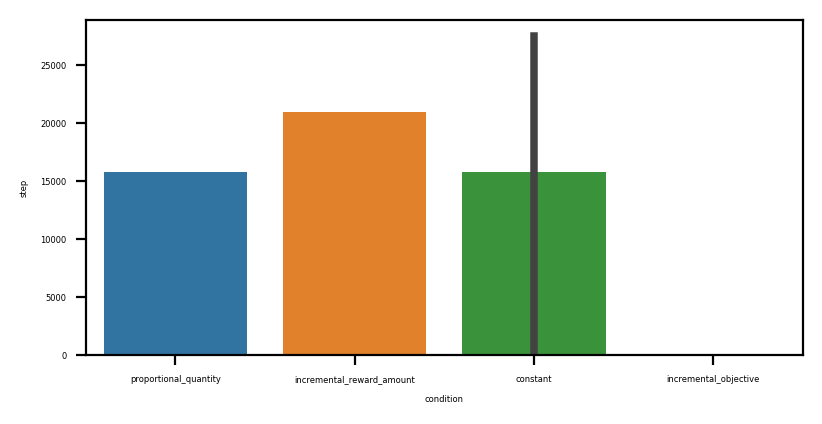

user 152A


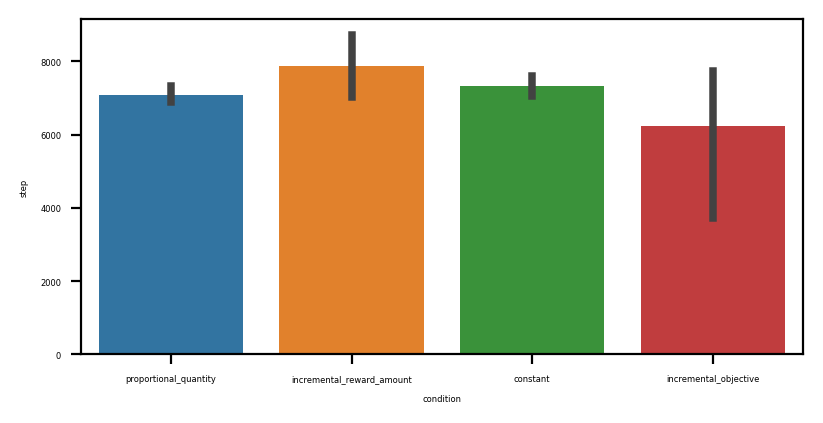

user 192Z


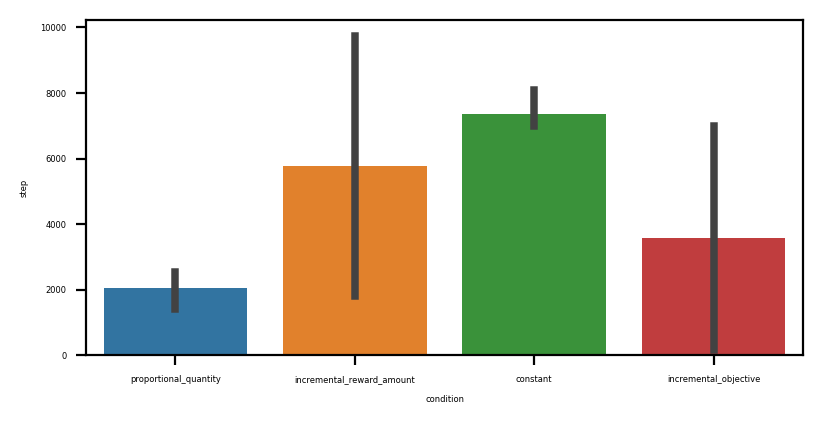

user 27SI


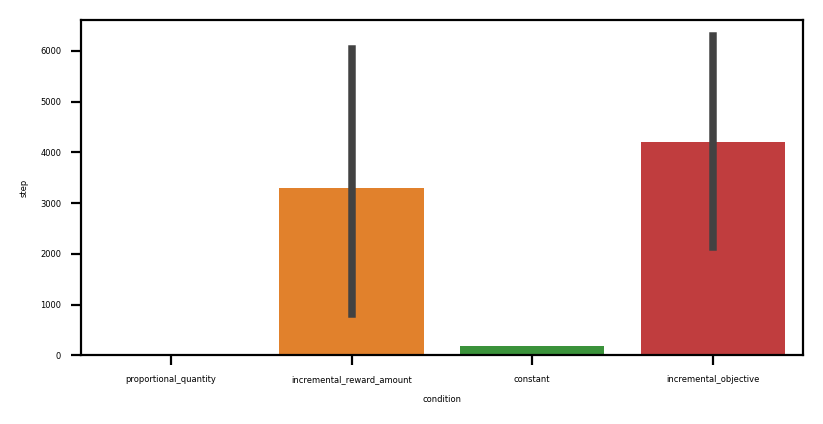

user 11AV


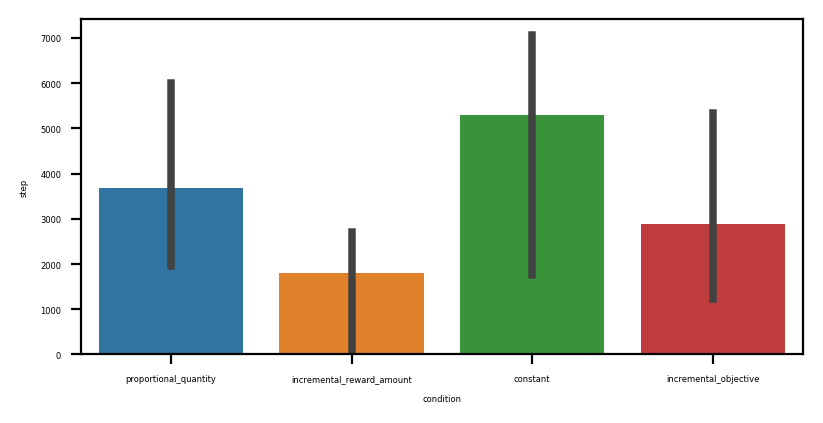

user 152O


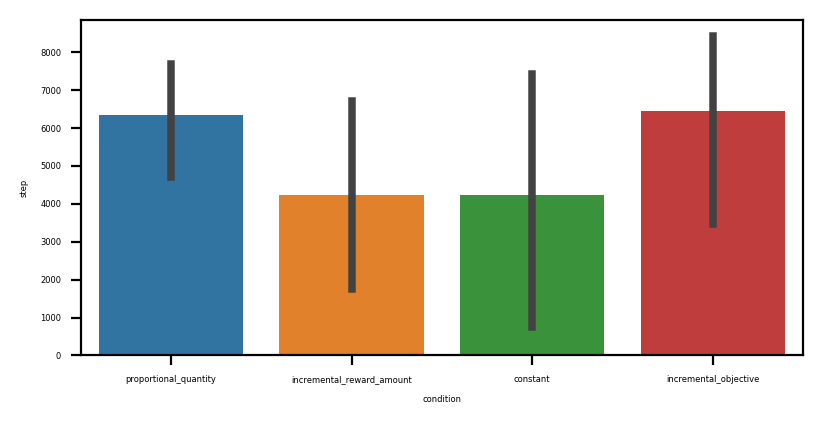

user 272L


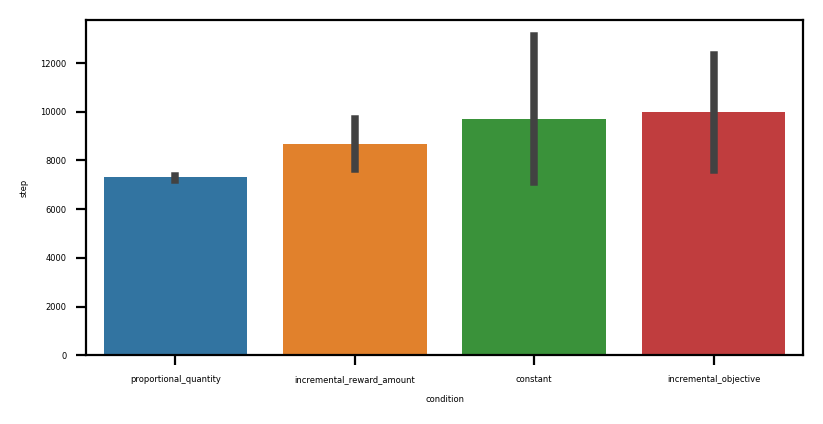

user 24SA


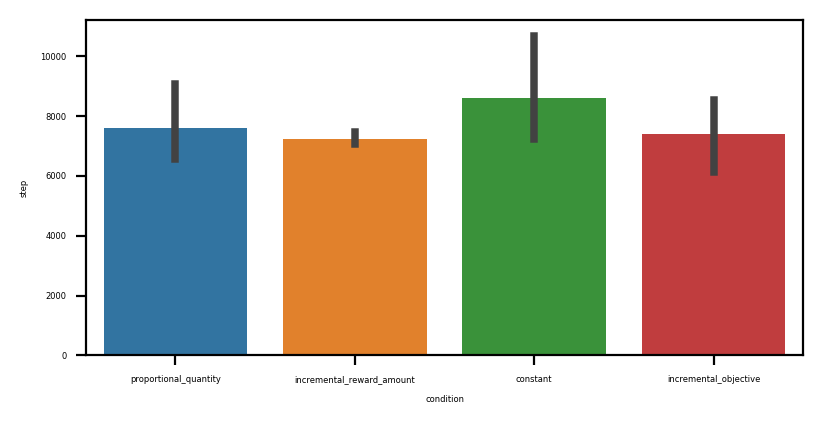

user 162W


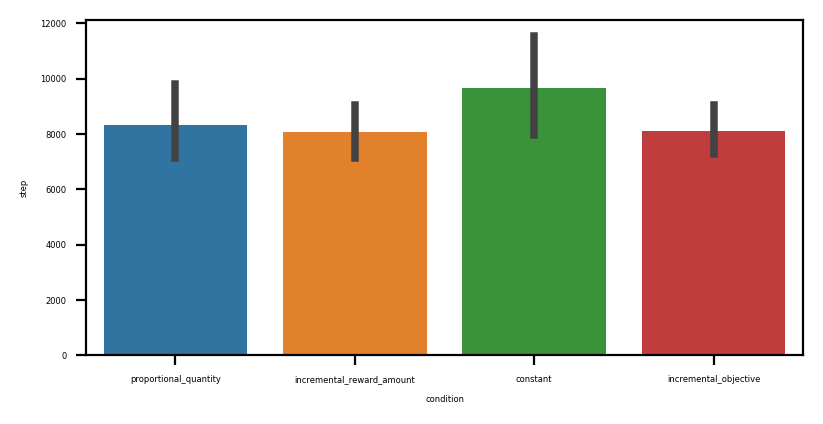

user 09AU


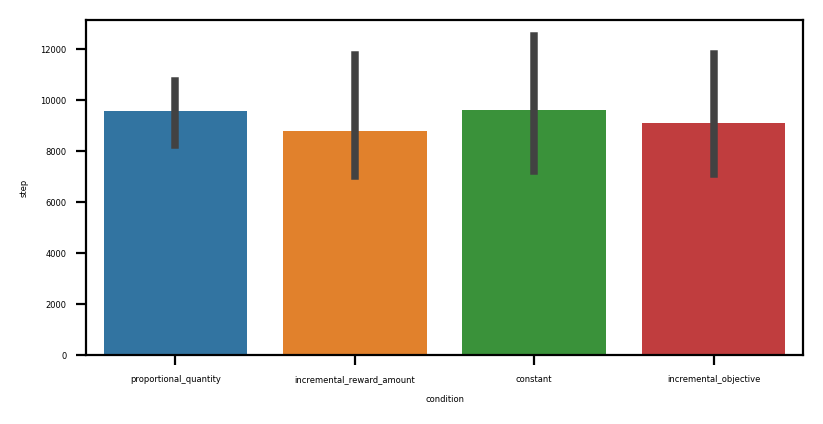

user 15SM


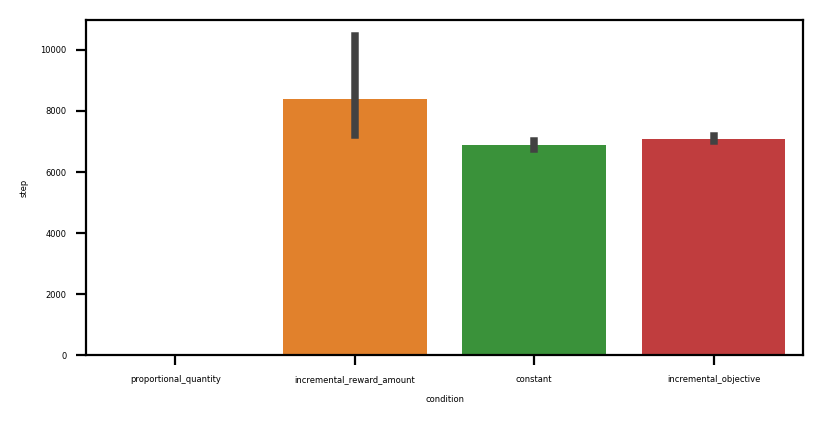

user 22MH


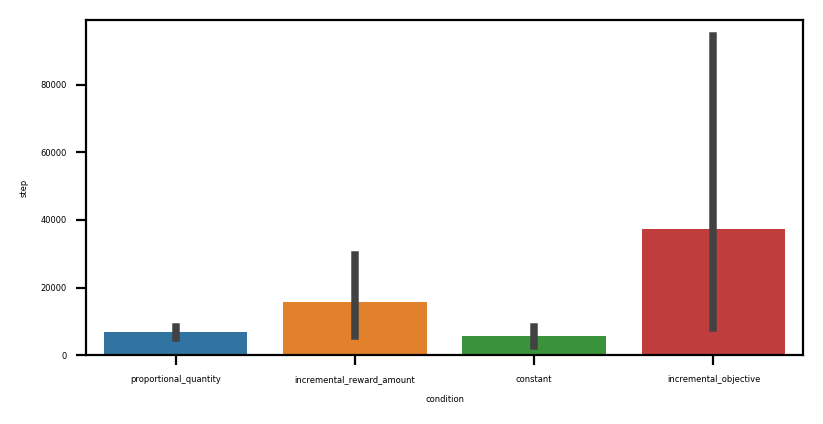

user 102P


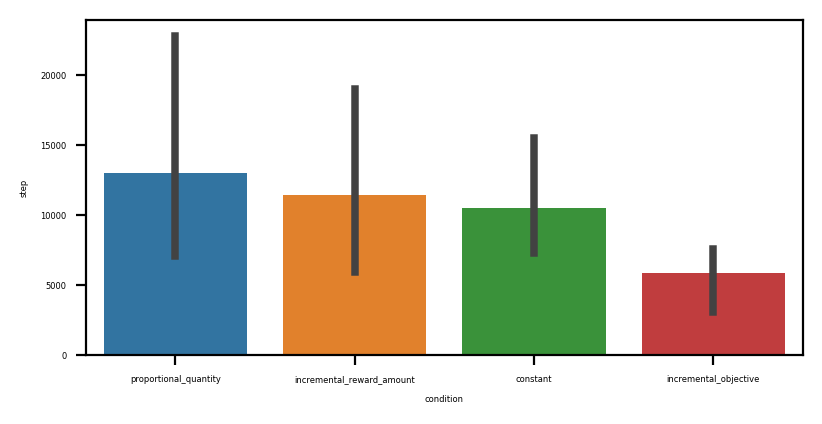

user 12JA


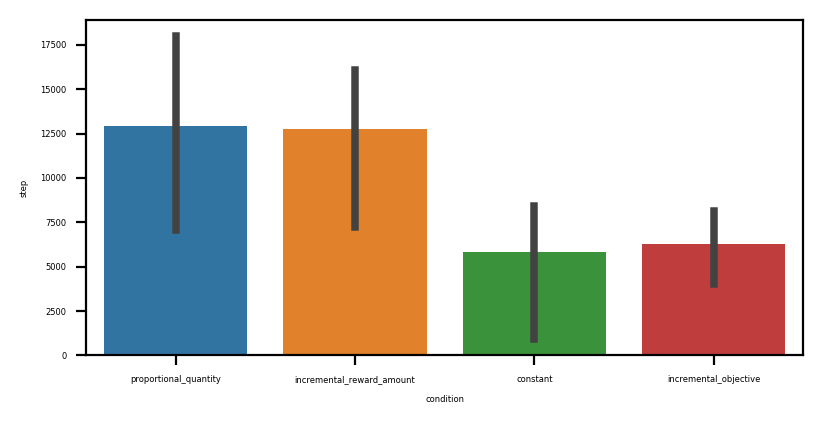

user 11SA


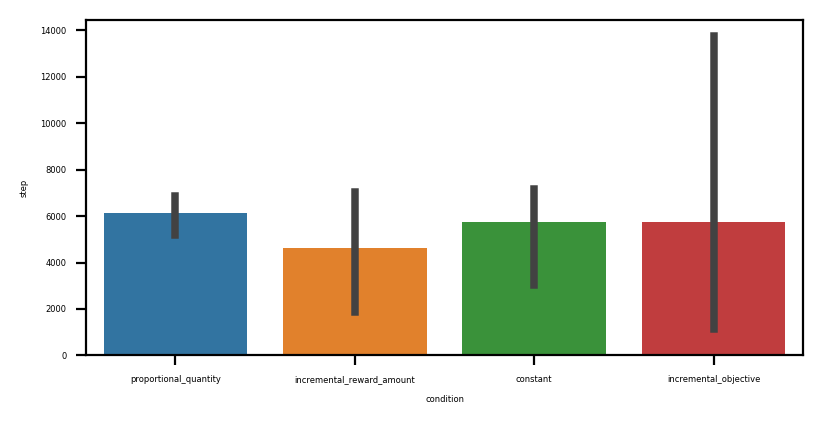

user 11KD


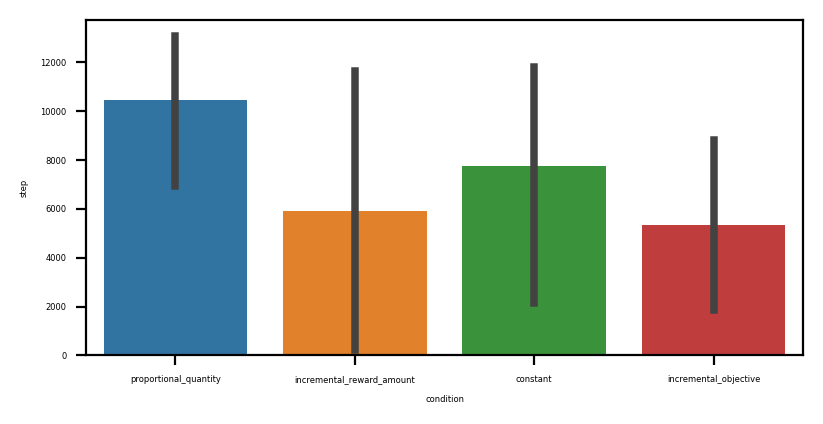

user 1362


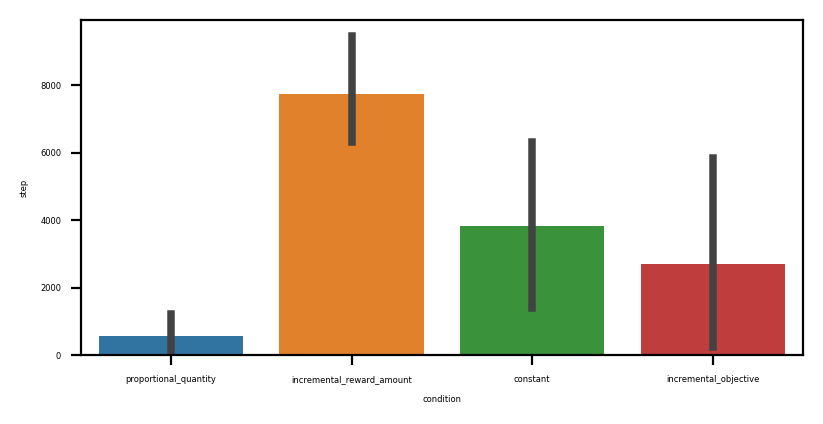

user 252S


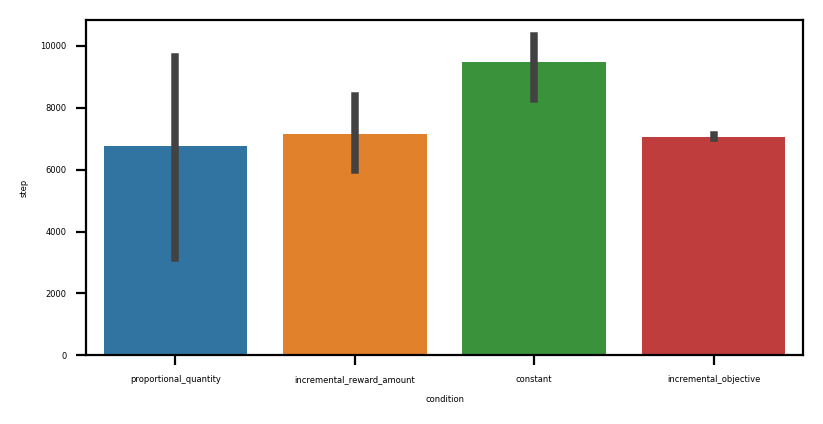

user 302M


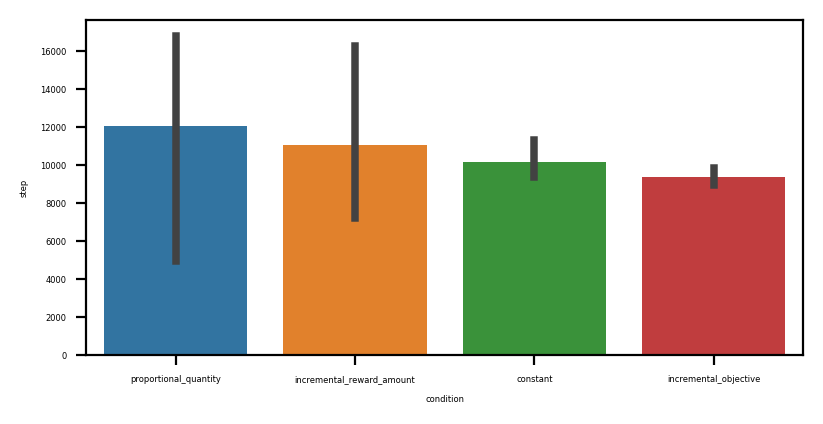

user 272W


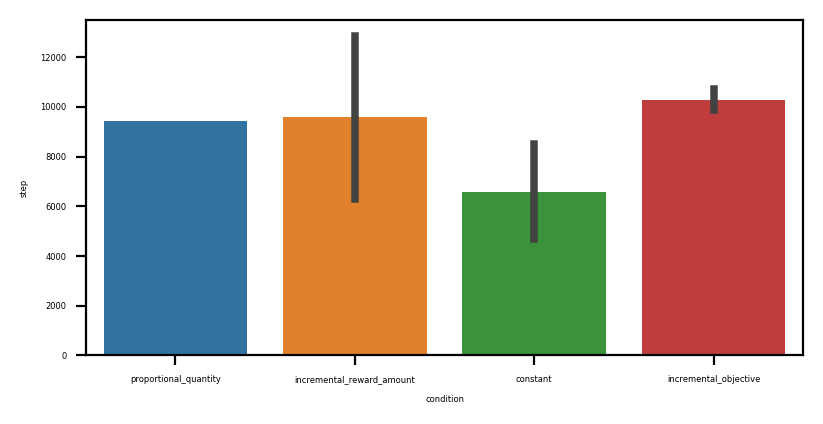

user 13KU


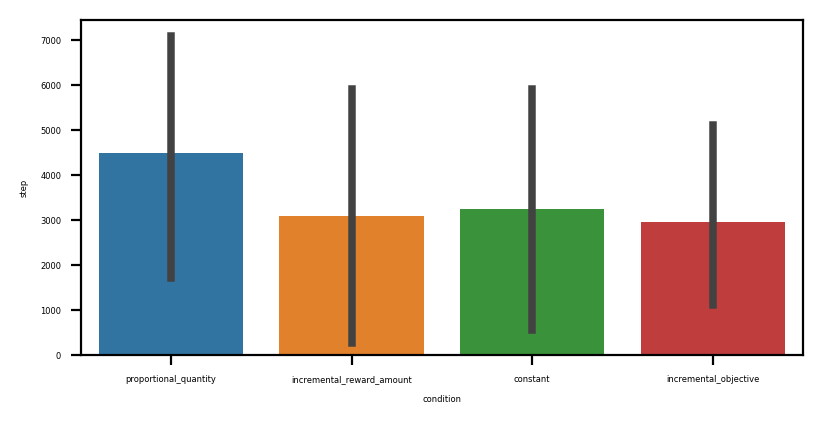

user 132L


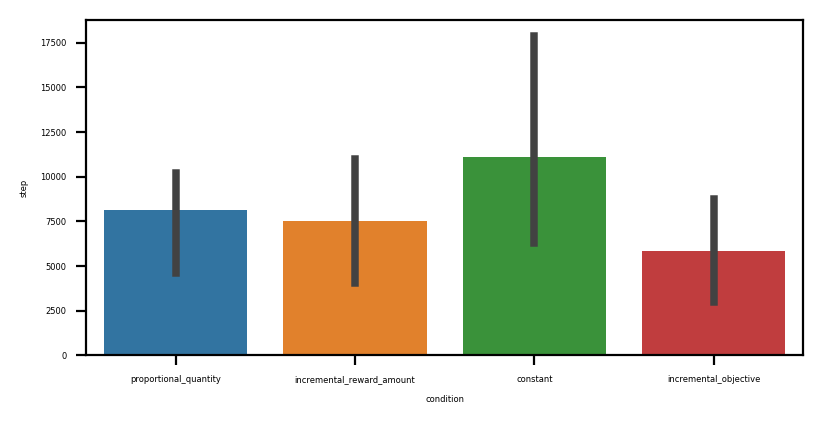

user 28OM


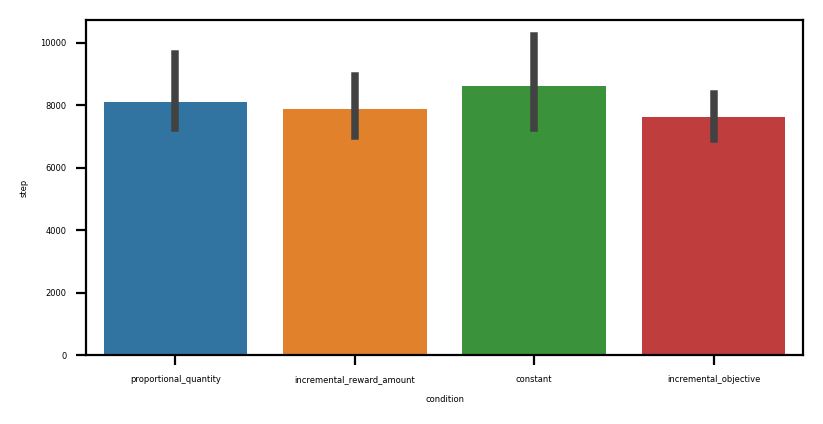

user 152G


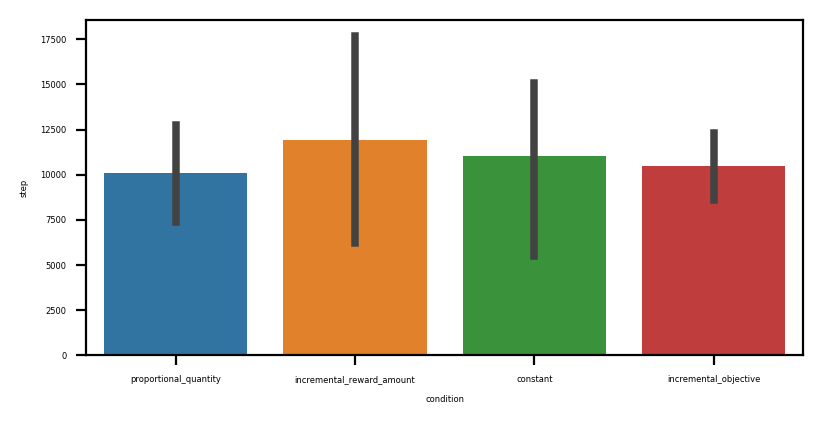

user 02MY


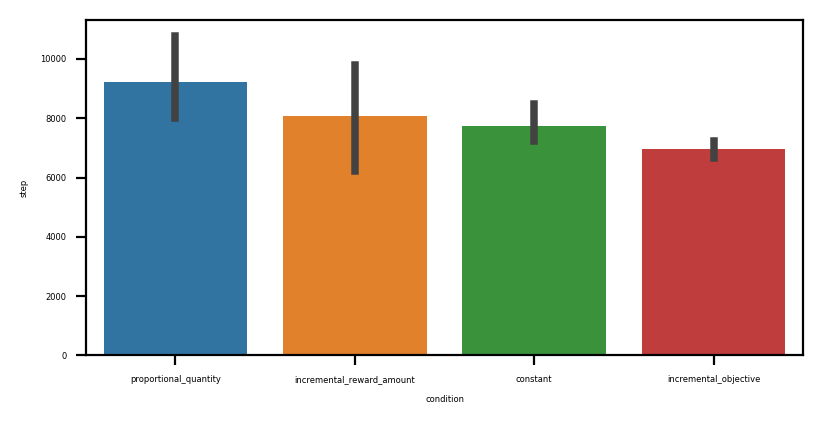

user 18DA


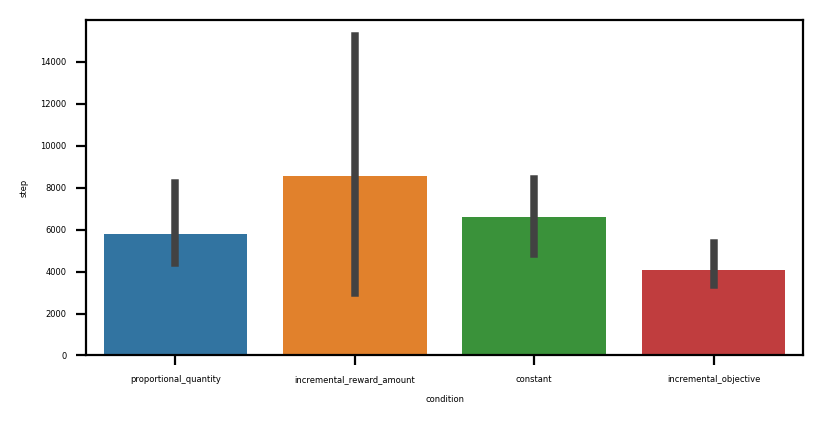

user 242K


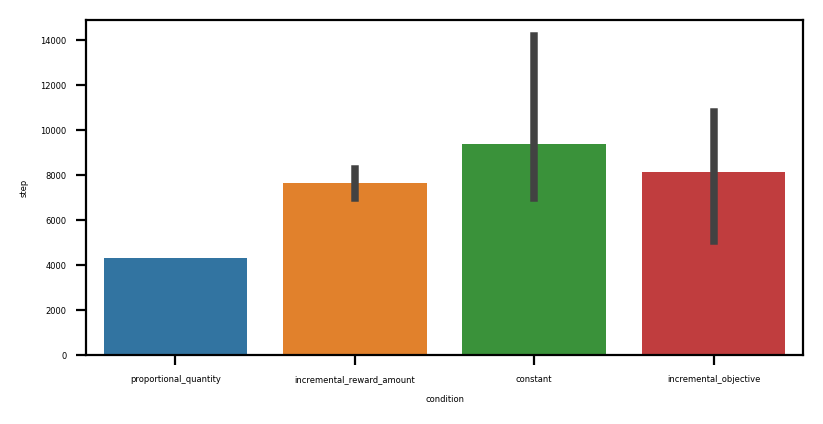

user 25J1


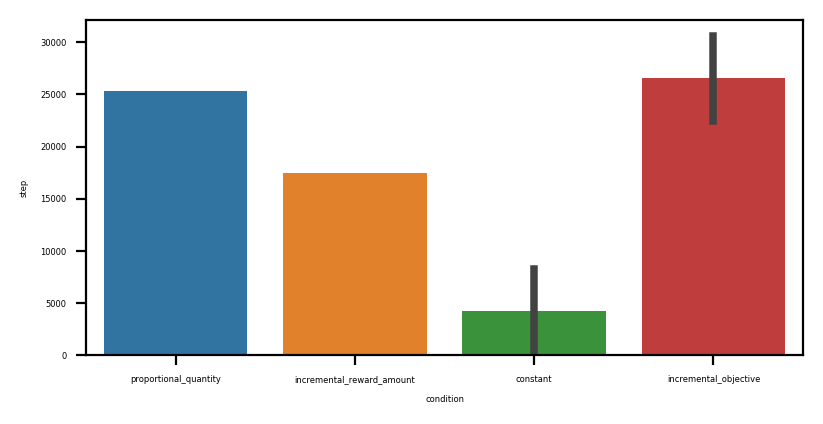

user 162G


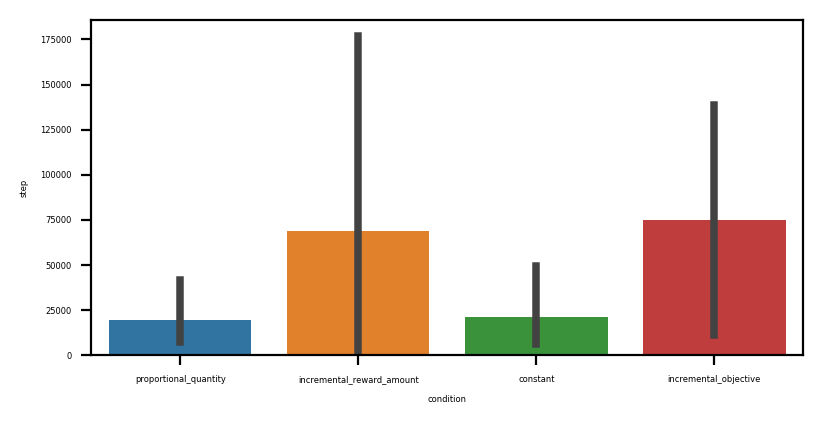

user 19AN


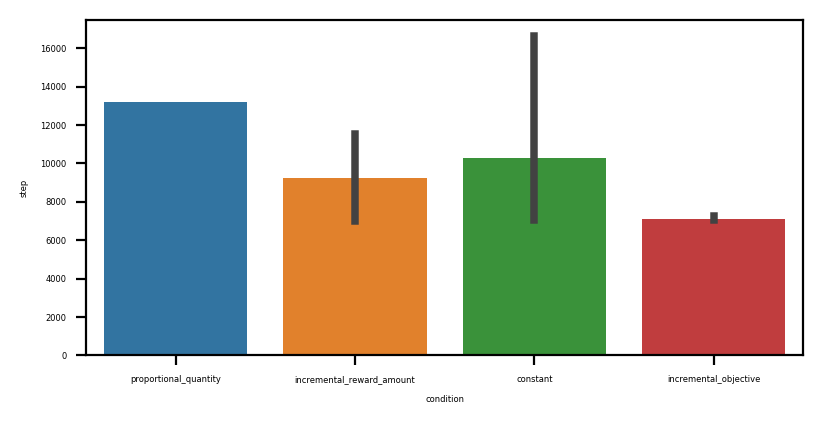

user 19EN


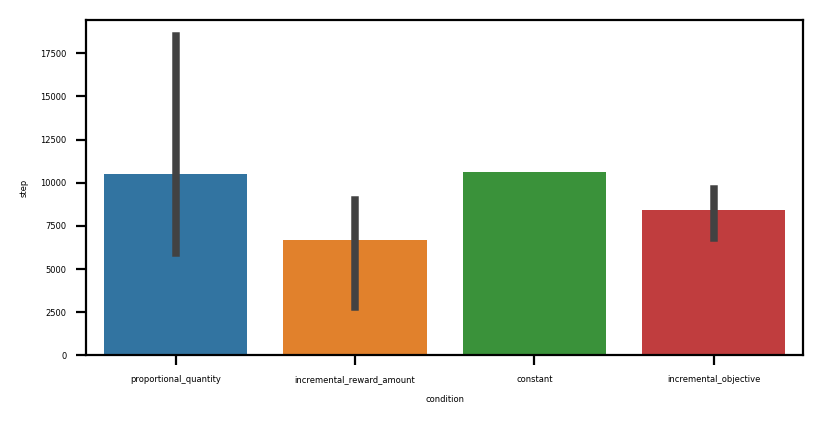

user 25TI


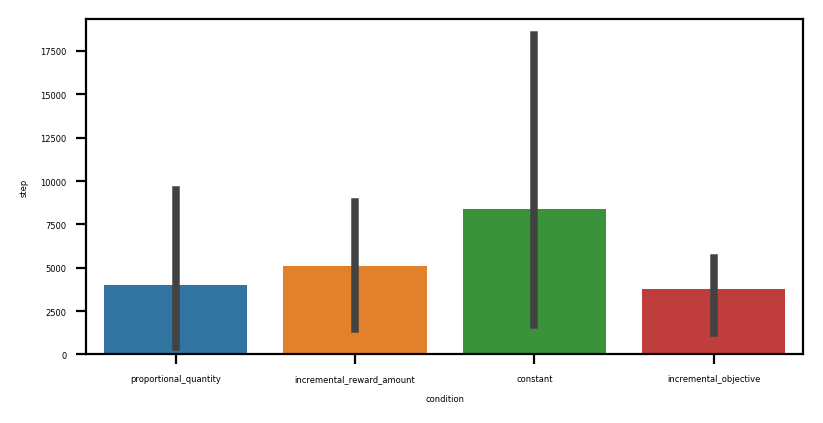

user 09A1


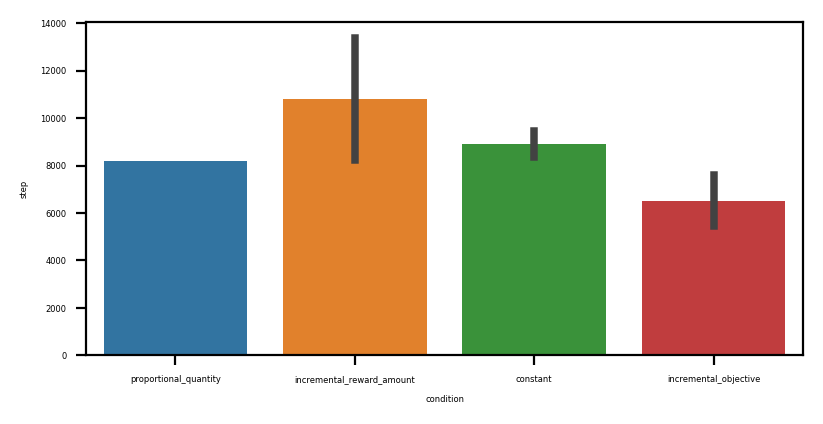

user 10AN


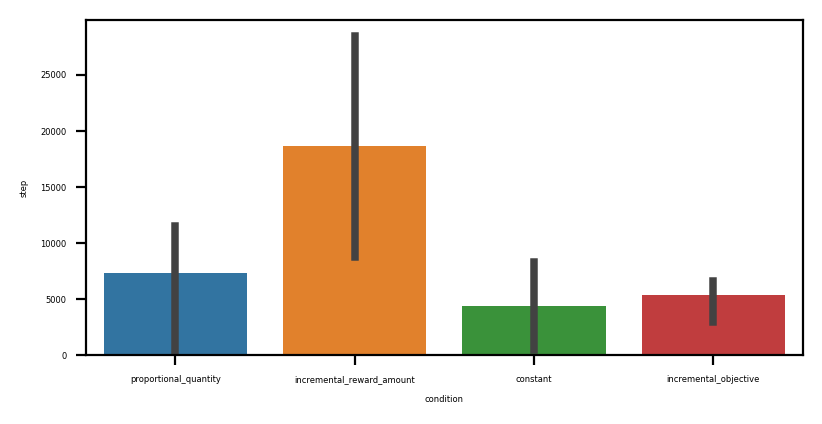

user 06AS


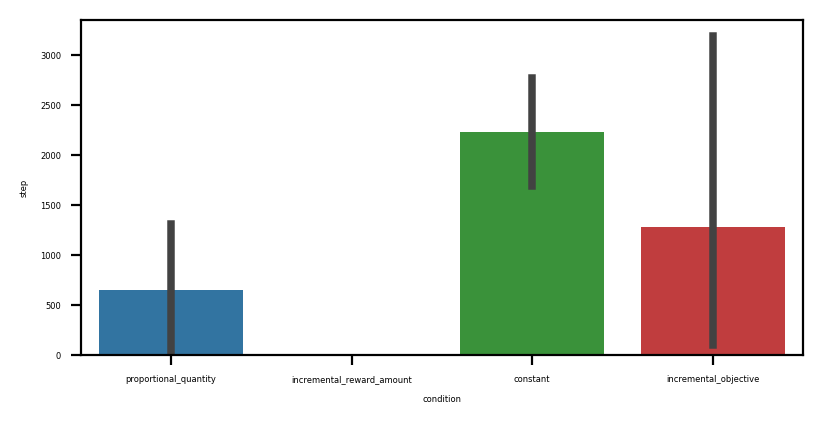

user 28E1


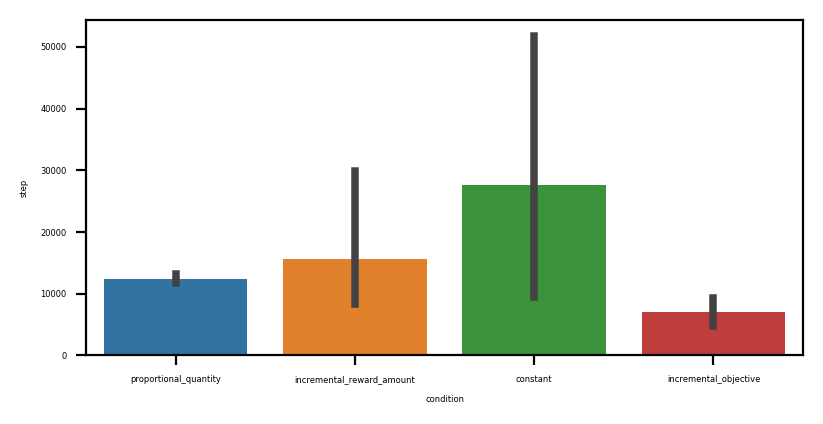

user 15MM


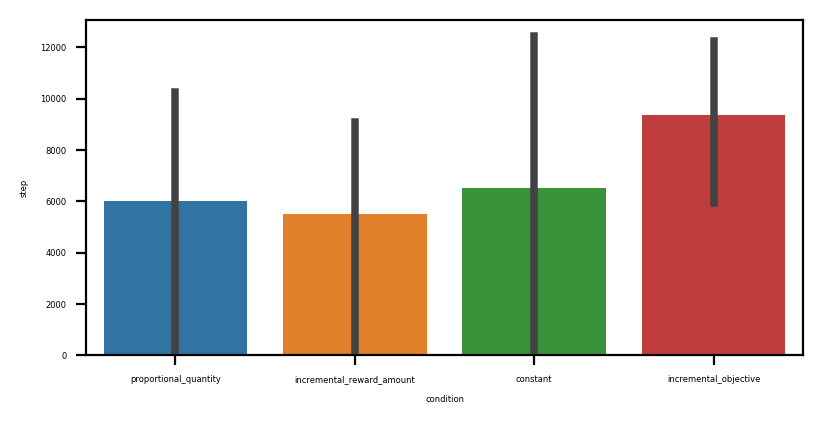

In [108]:
for user in df_step.user.unique():
    print("user", user)

    user_df = df_step[df_step.user == user]
    # print(user_df.groupby("condition").mean("step"))

    plt.rcParams.update({'font.size': 3})
    fig, ax = plt.subplots(figsize=(4, 2))
    sns.barplot(x="condition", y="step", data=user_df, ax=ax, order=order)
    fig.tight_layout()
    plt.show()